In [14]:
from PIL import Image
from torchvision import transforms as t
import cv2
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt

In [2]:
import sys
sys.path.append(r"E:/FeatureAgeNet")

In [46]:
# def get_img(url):
#     mean = [0.485, 0.456, 0.406]
#     std = [0.229, 0.224, 0.225]
#     img = Image.open(url)
#     transform = t.Compose([
#         t.Resize((224, 224)),
#         t.ToTensor(),
#         t.Normalize(mean=mean, std=std)
#     ])
#     input_tensor = transform(img)
#     input_tensor = torch.unsqueeze(input_tensor, 0)
#     return img, input_tensor

In [11]:
def get_img(url):
    img = cv2.imread(url)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    x = (np.float32(img) / 255.0 - mean) / std
    x = x.transpose((2, 0, 1))
    x = np.expand_dims(x, axis=0)
    x = torch.from_numpy(x)
    x = torch.tensor(x, dtype=torch.float)
    return img, x

In [10]:
img, input_tensor = get_img(r"E:\Dataset\morph2-224\009055_1M54.jpg")

E:\software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


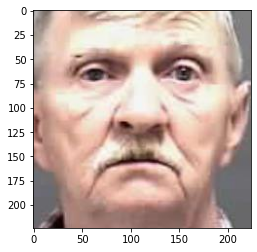

In [15]:
plt.imshow(img)

In [16]:
model = torch.load(r"E:\FeatureAgeNet\Logs\resnet_rank_224_224_size_90_epoches\best_all_model.pth")

In [17]:
model.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): R

In [12]:
target_layer = model.layer4[-1]

In [49]:
torch.sum(torch.sigmoid(model(input_tensor.cuda()))>0.5, axis=1)

tensor([54], device='cuda:0')

In [55]:
from pytorch_grad_cam import GradCAM
cam = GradCAM(model=model, target_layer=target_layer, use_cuda=True)
grayscale_cam = cam(input_tensor=input_tensor, target_category=54)

预测年龄为: tensor([54], device='cuda:0')


In [26]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [56]:
grayscale_cam.shape

(224, 224)

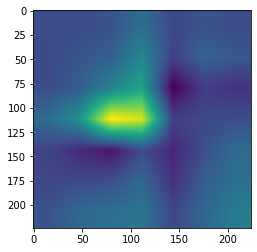

In [90]:
plt.imshow(grayscale_cam, cmap="jet")

In [29]:
from pytorch_grad_cam.utils.image import show_cam_on_image

In [31]:
grayscale_cam.shape

(120,)

In [70]:
# grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(img, grayscale_cam)

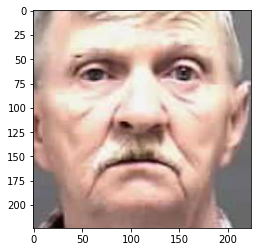

In [71]:
plt.imshow(visualization)

In [69]:
np.float32(img).max()

255.0

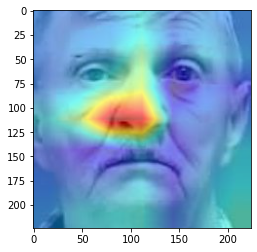

In [101]:
heatmap = cv2.applyColorMap(np.uint8(255 * (1-grayscale_cam)), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
cam = heatmap + np.float32(img) / 255
cam = cam / np.max(cam)
cam = np.uint8(255 * cam)
plt.imshow(cam, cmap="jet")


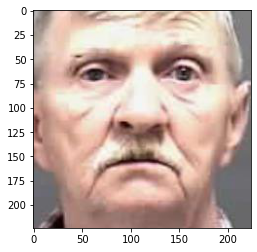

In [91]:
plt.imshow(img)

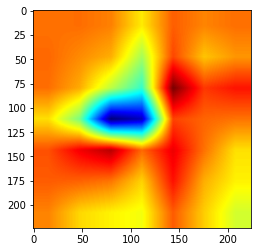

In [100]:
plt.imshow(heatmap)

In [25]:
# model._modules.get("layer4")
finalconv_name = 'layer4'

In [26]:
# hook
feature_blobs = []
def hook_feature(module, input, output):
    feature_blobs.append(output.cpu().data.numpy())
model._modules.get(finalconv_name).register_forward_hook(hook_feature)

In [27]:
params = list(model.parameters())

In [28]:
# get weight only from the last layer(linear)
weight_softmax = np.squeeze(params[-2].cpu().data.numpy())


In [ ]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    size_upsample = (224, 224)
    _, nc, h, w = feature_conv.shape
    output_cam = []
    cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)
    output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [39]:
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): R

In [29]:
y = model(input_tensor.cuda())

In [30]:
pred = torch.sum(torch.sigmoid(y)>0.5, axis=1)
pred

tensor([54], device='cuda:0')

In [34]:
feature_blobs[0].shape

(1, 512, 7, 7)

In [35]:
feature_conv = feature_blobs[0]
_, nc, h, w = feature_conv.shape  # 512, 7, 7

In [36]:
size_upsample = (224, 224)

In [ ]:
.dot(feature_conv.reshape((nc, h*w)))  # (1, 512)*(512, 49)

In [38]:
weight_softmax.shape

(512,)

In [ ]:
CAMs = returnCAM(feature_blobs[0], weight_softmax, [idx[0].item()])

In [40]:
model_features = nn.Sequential(*list(model.children())[:-2])

In [42]:
fc_weights = model.state_dict()['fc.weight'].cpu().numpy()

In [43]:
fc_weights.shape

(1, 512)

In [44]:
model.eval()
model_features.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(i

In [47]:
features = model_features(input_tensor.cuda()).detach().cpu().numpy()
features.shape

(1, 512, 7, 7)

In [49]:
y.shape

torch.Size([1, 100])

In [ ]:
bz, nc, h, w = features.shape 
output_cam = []
for idx in y:
    

In [17]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [20]:
a = np.array([
    [0,0,0  ,0,0,0],
    [0,0.2,0.2,0.2,0,0],
    [0,0.2,0.4 ,0.3,0.2,0],
    [0,0.2,0.7,0.5,0.2,0],
    [0,0.2,0.2,0.2,0,0],
    [0,0,0  ,0,0,0],
    [0,0,0  ,0,0,0],
    ], dtype="float32")
a = cv2.resize(a, (224,224))
a[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype

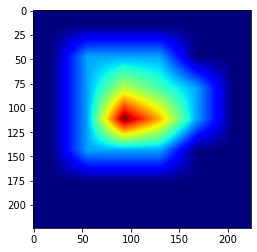

In [21]:

plt.imshow(a, cmap="jet")